# Assignment 2

## Part 1: Synthetic dataset

**Question 1** Start by generating a 2D dataset that has 3 Gaussian clusters. The first two should be as in the cluster creation exercise from class, i.e., cluster 1 should be centred at (10,10) and be spherical and cluster 2 should be centred at (0,0) and have contours in the shape of an ellipse (with a radius ratio of roughly 4:1), while the third cluster can be whatever you'd like as long as it is distinct from the first two but still has some overlap with one of them. Include a 1000 datapoints for each cluster.

**Question 2** Produce a scatter plot of your clusters, assigning each cluster a different color.

In [74]:
import numpy as np
import matplotlib.pyplot as plt

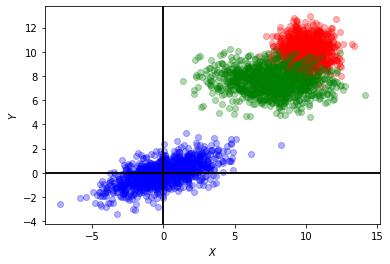

In [75]:
def createData(a, b, rho, a1, b1,rho1,a2, b2,rho2):
    data = np.random.multivariate_normal(mean = np.array([10, 10]), cov = np.array([[a, rho], [rho, b]]), size=(1000, ))
    plt.scatter(data[:, 0], data[:, 1],c='red', alpha=0.3)
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    data1 = np.random.multivariate_normal(mean = np.array([0, 0]), cov = np.array([[a1, rho1], [rho1, b1]]), size=(1000, ))
    plt.scatter(data1[:, 0], data1[:, 1],c='blue', alpha=0.3)
    plt.axvline(0, color='black')
    plt.axhline(0,color='black')
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    data2 = np.random.multivariate_normal(mean = np.array([7.5, 7.5]), cov = np.array([[a2, rho2], [rho2, b2]]), size=(1000, ))
    plt.scatter(data2[:, 0], data2[:, 1],c='green', alpha=0.3)
    plt.axvline(0, color='black')
    plt.axhline(0,color='black')
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    return data,data1,data2

data1, data2, data3 = createData(1,1,0.0,4,1,1.2,4,1,-0.2)

X = np.vstack([data1,data2,data3]) #data



In [76]:
#hyperparameters
nclusters = 3
niter = 100 

## Part 2: Clustering

Suppose you didn't know to which cluster each datapoint belonged to, and wanted to find out. One of the first things you might try is the following algorithm, where $k$ is a hyperparameters controlling the number of clusters we're trying to find:

1. Initialize the k cluster centroids, $\mu_1, \mu_2, \ldots, \mu_k$, randomly.
2. Repeat until convergence **(Question 1: what should the convergence criterion be?)**:
    1. Assign each datapoint to the cluster with the nearest centroid;
    2. Re-calculate the cluster centroids, i.e. the mean of all datapoints assigned to each cluster

**Question 2**: Implement this in Python. Define a Python class $\it{clustering}$, that takes as initialization parameters $\it{n_{clusters}}$, the number of clusters, $\it{n_{iter}}$, the maximum number of iterations of the above algorithm, and any other parameters you feel are needed to check for convergence (if any). The cluster centroids should be a class attribute. Define two methods, $\it{fit}$, taking in a set of points, $\mathbf{X}$ and performing clustering using the algorithm above,  and $\it{predict}$, that takes in a set of points and returns a prediction for which cluster those points belong to.

**Question 3**: Use your clustering class on the synthetic dataset you created in Part 1. Comment on how well it clusters your dataset. 

**Question 4**: How do the found clusters vary as you run the algorithm again?

# Question 1 What should the convergence criterion be?

Convergence criteria depends on the cost that is calculated using responsiblities and distances. When the cost decrease is less than some threshold (in below example we took .01%)
than the loop will break. That is how we are doing convergence.

$J = \sum_{n=1}^N\sum_{k=1}^K  r_k^n ||\vec{M}_k - \vec{X}^{(n)}||^2$

## Hard K-means

In [77]:
class Clustering_Kmeans:
    def __init__(self,clusters,iter):
        self.clusters = clusters
        self.iter = iter
        self.centroids = None
        self.cost_list = None
    def fit(self,X):
        self.centroids = np.random.uniform(np.min(X),np.max(X),self.clusters*2).reshape(self.clusters,2)
        responsiblities = np.zeros(X.shape[0]).astype(int)
        self.cost_list = []
        perc_change = []
        for iter in range(self.iter):
            #storing old responsiblities assigned
            old_responsiblities = responsiblities.copy()
            #find distances from each point
            distances = np.zeros((X.shape[0],self.clusters))
            for i in range(self.clusters):
                distances[:,i] = ((X-self.centroids[i])**2).sum(axis=1)**0.5
            #finding cluster for that point using min disance
            responsiblities = np.argmin(distances, axis=1)
            #updating new centroids
            for i in range(self.clusters):
                if (i in np.unique(responsiblities)):
                    self.centroids[i,:] = X[responsiblities == i].mean(axis=0)
            #claculate cost and append
            cost = 0
            for i in range(X.shape[0]):
                cost += distances[i][responsiblities[i]]
            self.cost_list.append(cost)              
            #early convergence check
            if(iter > 1):
                perc_change.append(np.abs(self.cost_list[iter]-self.cost_list[iter-1])/self.cost_list[iter-1]*100)
                # below condition shows if cost percentange change is less than .01% then break the loop
                if(perc_change[-1]<=.01):
                    print("Converged after {iter} iterations".format(iter = iter))
                    self.iter = iter+1
                    break

    def predict(self,X):
        distances = np.zeros((X.shape[0],self.clusters))
        responsiblities = np.zeros(X.shape[0]).astype(int)
        for i in range(self.clusters):
                distances[:,i] = ((X-self.centroids[i])**2).sum(axis=1)**0.5
        responsiblities = np.argmin(distances, axis=1)
        plt.scatter(X[:,0],X[:,1],c=responsiblities,alpha=0.3)


Converged after 11 iterations


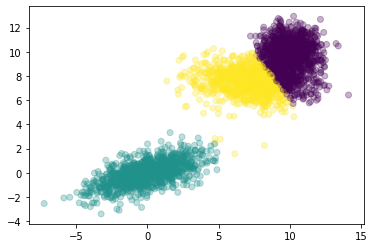

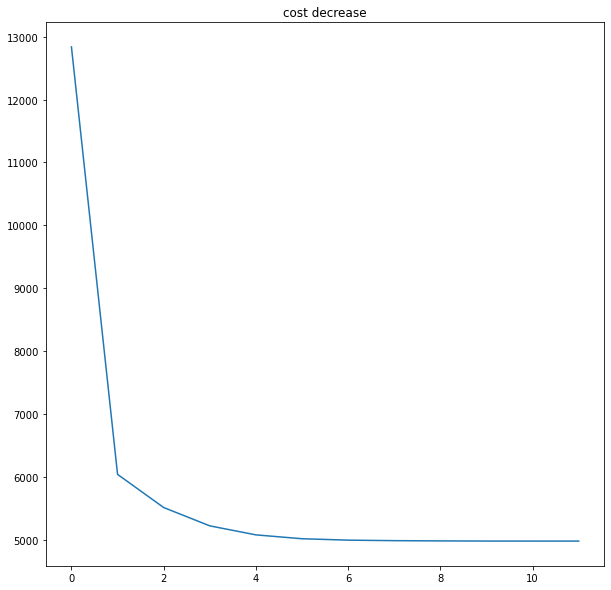

In [78]:
c_obj =  Clustering_Kmeans(nclusters,niter)
c_obj.fit(X)
c_obj.predict(X)
fig2 = plt.figure(figsize=(10,10))
ax1 = fig2.add_subplot(111) 
ax1.set_title('cost decrease')
ax1.plot(range(c_obj.iter),c_obj.cost_list)


## EM Algorithm

In [79]:
# below code is not vectorized it was just imlemented to check how EM alo works and is not asked in assignment.
class Clustering_EM:
    def __init__(self,clusters,iter):
        self.clusters = clusters
        self.iter = iter
        self.mu = None
        self.pi = None
        self.cov = None

    def pdf(self,X, mean, variance):

        return np.array([(1. / (np.sqrt((2 * np.pi)**2 * np.linalg.det(variance))) * 
                np.exp(-(np.linalg.solve(variance, x-mean).T.dot(x-mean)) / 2)) for x in iter(X)])
    
    def fit(self,X):
        #initilalize value of mu, cov_matrix and mixing proportions(pi)
        self.mu = np.random.randint(min(X[:,0]),max(X[:,0]),size=(self.clusters,len(X[0])))
        self.cov = np.zeros((self.clusters,len(X[0]),len(X[0])))
        for dim in range(len(self.cov)):
            np.fill_diagonal(self.cov[dim],5)
        self.pi = np.ones(self.clusters)/self.clusters

        # this will store soft values of that point being in that cluster and then we will argmax that value
        log_likelihoods = []
        perc_change = []
        #running loop for no of iterations
        for i in range(self.iter):
            #E-Step
                responsiblities = np.zeros((len(X),len(self.cov)))
                for mean,variance,mix_proportion,index in zip(self.mu,self.cov,self.pi,range(len(responsiblities[0]))):
                    responsiblities[:,index] = mix_proportion*self.pdf(X,mean,variance)/np.sum( [pi_den*self.pdf(X,mean_den,variance_den) for
                    pi_den,mean_den,variance_den in zip(self.pi,self.mu,self.cov)],axis=0)
                    
            #M-Step
                self.mu = []
                self.cov = []
                self.pi = []
                for c in range(len(responsiblities[0])):
                    m_c = np.sum(responsiblities[:,c],axis=0)
                    mu_c = (1/m_c)*np.sum(X*responsiblities[:,c].reshape(len(X),1),axis=0)
                    self.mu.append(mu_c)

                    self.cov.append(((1/m_c)*np.dot((np.array(responsiblities[:,c]).reshape(len(X),1)*(X-mu_c)).T,(X-mu_c))))

                    self.pi.append(m_c/np.sum(responsiblities))
                log_likelihoods.append(np.log(np.sum([k*self.pdf(X,self.mu[i],self.cov[j]) for k,i,j in zip(self.pi,range(len(self.mu)),range(len(self.cov)))])))
                #early convergence check
                if(i > 1):
                    perc_change.append(np.abs(log_likelihoods[i]-log_likelihoods[i-1])/log_likelihoods[i-1]*100)
                    # below condition shows if Log likelihood percentange increase change is less than .001% then break the loop
                    if(perc_change[-1]<=.001):
                        print("Converged after {iter} iterations".format(iter = i))
                        break
        return np.argmax(responsiblities,axis=1),log_likelihoods,i

    def predict(self,X):
        pred,log_lik,iterations = self.fit(X)
        plt.scatter(X[:,0],X[:,1],c=pred,alpha=0.3)
        fig2 = plt.figure(figsize=(10,10))
        ax1 = fig2.add_subplot(111) 
        ax1.set_title('Log-Likelihood')
        ax1.plot(range(iterations+1),log_lik)
        



Converged after 68 iterations


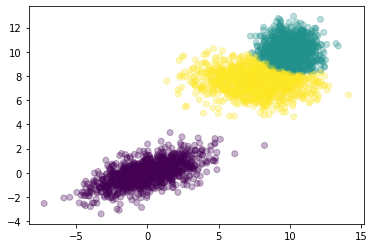

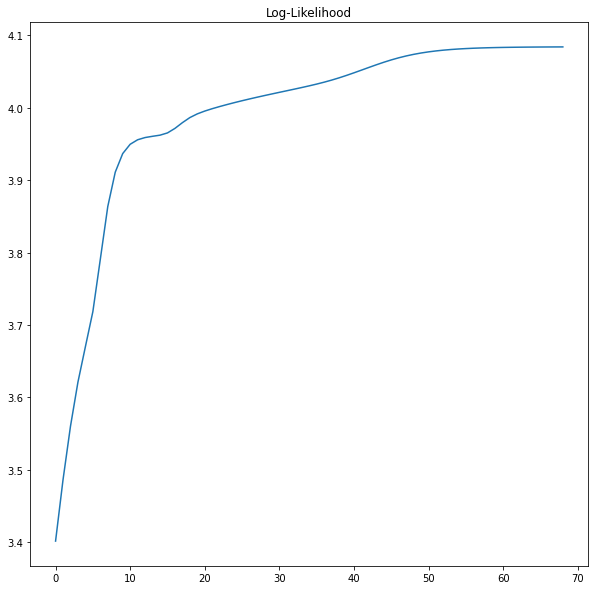

In [83]:
obj =  Clustering_EM(nclusters,niter)
obj.predict(X)


# **Question 3**: Use your clustering class on the synthetic dataset you created in Part 1. Comment on how well it clusters your dataset. 

As we are doing hard K-means beacuse of that decision boundry between clusters is not optimized. As in hard K means we give only 0 or 1 reponsiblity to a particular cluster rather than probabilitis i.e why we didnot got that good clusters.

second it depends upon number of k ie no of cluster taken on starting, as from our data we already know we have 3 clusters so when we take k = 3 it give somewhat give good results but not the best as it would have given with density based clustering.

For curiosity, to see how density based clustering will work on our dataset we also implemented EM algorithm and found out that it outperformed hard k-means.

# **Question 4**: How do the found clusters vary as you run the algorithm again

When we ran algoritm again and again we saw that a ties our alogo stuks in local minima and because of that it didnot gave good clustering results like a time it might only give 2 clusters and will not assign any point to third cluster if k = 3.

It also depends on that what random values centroids got assigned at first. Because of that it might stuck in local minima at might not good the best clusters.

Converged after 6 iterations


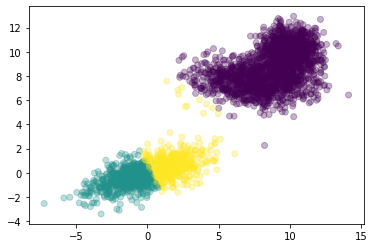

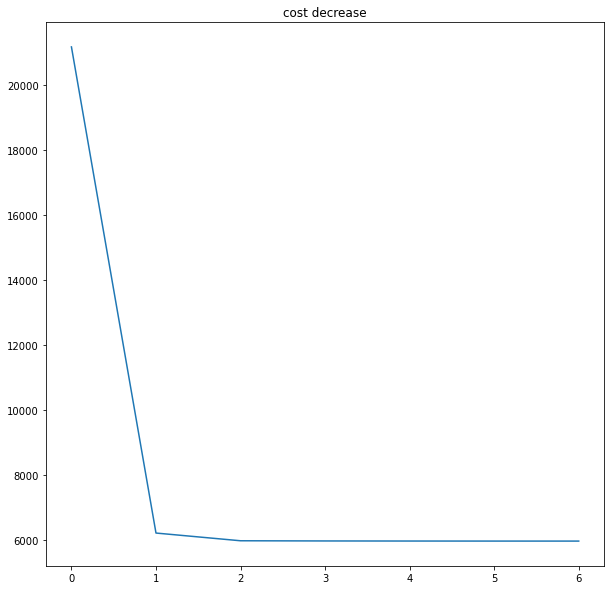

In [81]:
c_obj =  Clustering_Kmeans(nclusters,niter)
cost_list = c_obj.fit(X)
c_obj.predict(X)
fig2 = plt.figure(figsize=(10,10))
ax1 = fig2.add_subplot(111) 
ax1.set_title('cost decrease')
ax1.plot(range(c_obj.iter),c_obj.cost_list)

Converged after 7 iterations


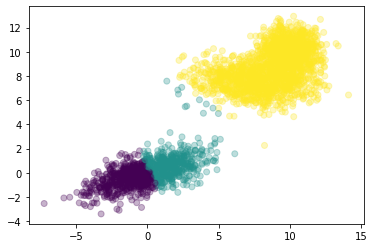

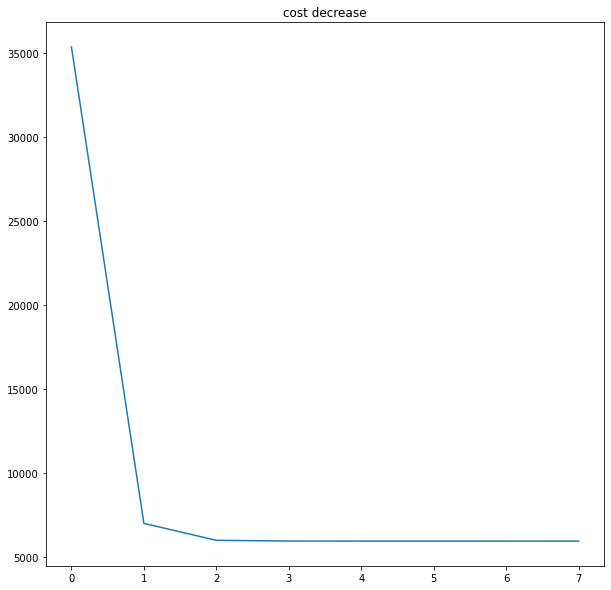

In [82]:
c_obj =  Clustering_Kmeans(nclusters,niter)
cost_list = c_obj.fit(X)
c_obj.predict(X)
fig2 = plt.figure(figsize=(10,10))
ax1 = fig2.add_subplot(111) 
ax1.set_title('cost decrease')
ax1.plot(range(c_obj.iter),c_obj.cost_list)